In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

## SIRD model in Python 

In [13]:
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = (-beta * S * I) / N
    dIdt = (beta * S * I / N) - gamma * I
    dRdt = gamma * I
    dDdt = dRdt*rho
    return dSdt, dIdt, dRdt, dDdt

## Graph SIRD model

In [110]:
def plotSIRD(tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    # Plotting SIRD data point
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
    ax.plot(t, D, 'y', alpha=0.5, lw=2, label='Deceased')

    # Creating Labels for graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    plt.fill_between(t, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return ax, D
    

In [120]:
def plotRealData (graph, data, offset, beforeForecast, D):
    deaths = data["cumDeath"].tolist()
    t = np.linspace(0, 100, 100)
    if (offset != 0):
        graph.plot(t[0:offset], deaths[0:offset], 'r', marker='.', linestyle = 'None')
        graph.plot(t[offset:beforeForecast], deaths[offset:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    else:
        graph.plot(t[0:beforeForecast], deaths[0:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    plt.fill_between(t[beforeForecast:len(t)], D[beforeForecast:len(t)], deaths[beforeForecast:len(t)], alpha=0.5, edgecolor='black', label="Death Difference")
    legend = graph.legend()
    legend.get_frame().set_alpha(0.5)
    

## Test

### Before

/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_10490/2601597332.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


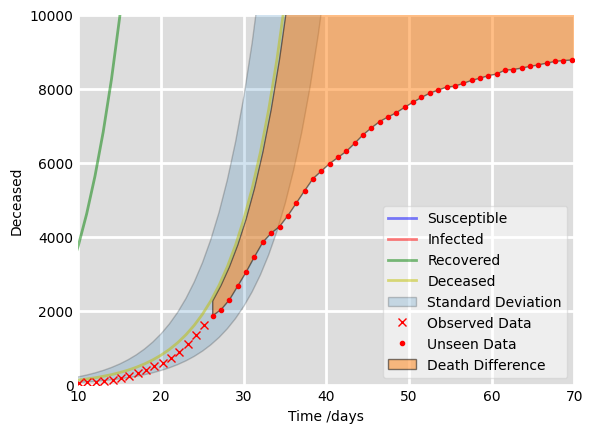

In [121]:
SIRD_graph = plotSIRD(1000,83000000, 8297.62180	,0.18755,0.01716,0.03265,[0,10000],[10,70], [0.00689,0.00576,0.00877])
plotRealData(SIRD_graph[0],pd.read_csv('../processed_data/cumDeathGermany.csv'), 0,26, SIRD_graph[1])

### After

/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_10490/2601597332.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


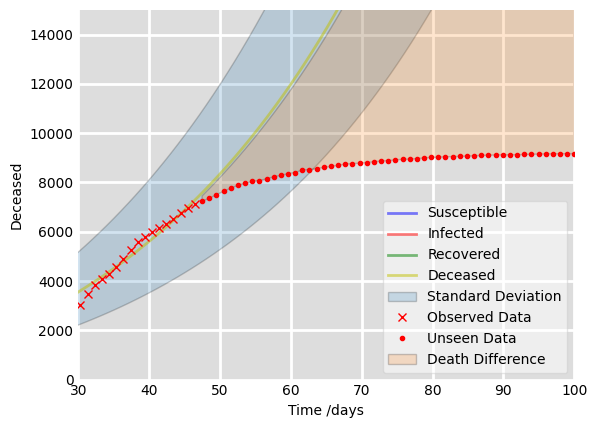

In [117]:
SIRD_graph = plotSIRD(1000,83000000, 8301.01060,0.23074,0.20158,0.04435,[0,15000],[30,100], [0.04656,0.04752,0.00880])
plotRealData(SIRD_graph[0],pd.read_csv('../processed_data/cumDeathGermany.csv'), 30,47, SIRD_graph[1])